# Classifiers

In this notebook we will look at the impact on accuracy of a model when we use imbalanced data. We will compare classifiers as on the Uncertainty sampling we saw in the last notebook.
***

In [1]:
## Imports ##

import numpy as np

# matplotlib
import matplotlib as mlp
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier

# skactiveml
from skactiveml.classifier import SklearnClassifier, ParzenWindowClassifier, MixtureModelClassifier
from skactiveml.pool import UncertaintySampling
from skactiveml.pool import QueryByCommittee
from skactiveml.pool import RandomSampling
from skactiveml.utils import unlabeled_indices, labeled_indices, MISSING_LABEL
from skactiveml.visualization import plot_decision_boundary, plot_utilities

# set warnings
import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

Most lineair classifiers do NOT work because the wrapper function SklearnClassifier calls a method predict_proba

In [2]:
def get_data(weights=None, random_state=0):
    X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, random_state=random_state)
    Xi, yi = make_classification(n_samples=100, n_features=2, n_redundant=0, weights=weights, random_state=random_state)
    return (X, y, Xi, yi)

In [3]:
def get_accuracy_linear_classifier(classifier, weights=None, cycles=30, **kwargs):
    data = []
    for rand in range(100):
        qs = UncertaintySampling(random_state=rand, **kwargs)
        X, y_true, Xi, yi_true = get_data(weights=weights, random_state=rand)
        yi = np.full(shape=yi_true.shape, fill_value=MISSING_LABEL)
        out = []
        clf = SklearnClassifier(classifier, classes=np.unique(y_true))

        clf.fit(Xi, yi)
        for _ in range(cycles):
            i = qs.query(Xi, yi, clf)
            yi[i] = yi_true[i]
            clf.fit(Xi,yi)
            out.append(clf.score(X,y_true))
        data.append(out)

    return np.mean(np.array(data), axis=0)

def get_accuracy_parzenwindow_classifier(weights=None, cycles=30, **kwargs):
    data = []
    for rand in range(100):
        qs = UncertaintySampling(random_state=rand, **kwargs)
        X, y_true, Xi, yi_true = get_data(weights=weights, random_state=rand)
        yi = np.full(shape=yi_true.shape, fill_value=MISSING_LABEL)
        out = []
        clf = ParzenWindowClassifier(classes=np.unique(y_true))

        clf.fit(Xi, yi)
        for _ in range(cycles):
            i = qs.query(Xi, yi, clf)
            yi[i] = yi_true[i]
            clf.fit(Xi,yi)
            out.append(clf.score(X,y_true))
        data.append(out)

    return np.mean(np.array(data), axis=0)

def get_accuracy_mixture_model(weights=None, cycles=30, **kwargs):
    data = []
    for rand in range(100):
        qs = UncertaintySampling(random_state=rand, **kwargs)
        X, y_true, Xi, yi_true = get_data(weights=weights, random_state=rand)
        yi = np.full(shape=yi_true.shape, fill_value=MISSING_LABEL)
        out = []
        clf = MixtureModelClassifier(classes=np.unique(y_true))

        clf.fit(Xi, yi)
        for _ in range(cycles):
            i = qs.query(Xi, yi, clf)
            yi[i] = yi_true[i]
            clf.fit(Xi,yi)
            out.append(clf.score(X,y_true))
        data.append(out)

    return np.mean(np.array(data), axis=0)

In [4]:
def plot_accuracy(title, accuracies, ax):
    c = np.arange(len(accuracies[0][0]))
    for i in range(len(accuracies)):
        ax.plot(c, accuracies[i][0], label=accuracies[i][1])

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Samples asked at oracle')
    ax.set_title(title)
    ax.legend()


In [5]:
acc_logistic_regression = get_accuracy_linear_classifier(LogisticRegression())

In [6]:
acc_sgd_classifier = get_accuracy_linear_classifier(SGDClassifier(loss='modified_huber'))

In [7]:
acc_mlp_classifier = get_accuracy_linear_classifier(MLPClassifier())

In [8]:
acc_parzen_window = get_accuracy_parzenwindow_classifier()

In [9]:
acc_mixture_model = get_accuracy_mixture_model()

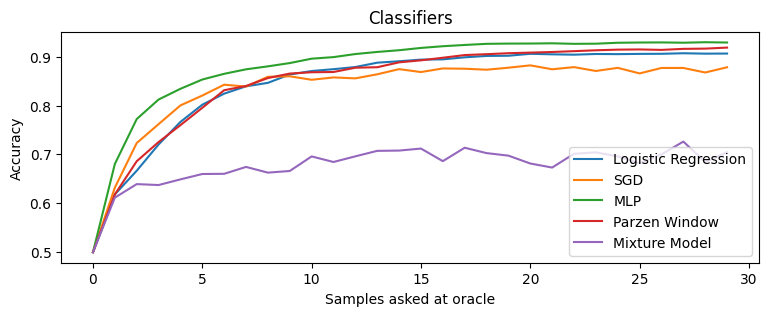

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 3))

plot_accuracy('Classifiers', [[acc_logistic_regression, "Logistic Regression"],
                              [acc_sgd_classifier, "SGD"],
                              [acc_mlp_classifier, "MLP"],
                              [acc_parzen_window, "Parzen Window"],
                              [acc_mixture_model, "Mixture Model"]
                             ], axs)

fig.show()

We can see that not much changes and the linear classifiers all perform well on the imbalanced data. Except for the Mixture model classifier which performs suprisingly badly.